In [22]:
import os
import requests
import tarfile

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [54]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories\\accordion', '101_ObjectCategories\\anchor', '101_ObjectCategories\\ant', '101_ObjectCategories\\barrel', '101_ObjectCategories\\bass', '101_ObjectCategories\\beaver', '101_ObjectCategories\\binocular', '101_ObjectCategories\\bonsai', '101_ObjectCategories\\brain', '101_ObjectCategories\\brontosaurus', '101_ObjectCategories\\buddha', '101_ObjectCategories\\butterfly', '101_ObjectCategories\\camera', '101_ObjectCategories\\cannon', '101_ObjectCategories\\car_side', '101_ObjectCategories\\ceiling_fan', '101_ObjectCategories\\cellphone', '101_ObjectCategories\\chair', '101_ObjectCategories\\chandelier', '101_ObjectCategories\\cougar_body', '101_ObjectCategories\\cougar_face', '101_ObjectCategories\\crab', '101_ObjectCategories\\crayfish', '101_ObjectCategories\\crocodile', '101_ObjectCategories\\crocodile_head', '101_ObjectCategories\\cup', '101_ObjectCategories\\dalmatian', '101_ObjectCategories\\dollar_bill', '101_ObjectCategories\\dolphin', '101_ObjectCategories\

In [55]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [56]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

In [57]:
random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [58]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [59]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

# Verificar a distribuição das categorias em cada conjunto
print("Distribuição no treino:", np.bincount(y_train))
print("Distribuição na validação:", np.bincount(y_val))
print("Distribuição no teste:", np.bincount(y_test))

Distribuição no treino: [ 37  35  35  31  40  31  24  86  69  29  64  65  40  27  87  34  41  39
  73  31  46  50  43  39  37  46  45  39  42  45  64  51  37  47  55  48
  49  27  21  25  38  73  64  29  29  61  57  23  43  59  78  39  54 139
  54  30  49  26  27  64  21  55  37  24  28  32  23  32  38  27  39  56
  43  37  24  44  27  56  41  21  45  33  63  42  44  21  60  38  50  59
 180  30  37  26  42  25  36]
Distribuição na validação: [ 7  5  5  9  9  8  3 25 15  7 12 15  6  9 18  5  9 12 15  8 10  9 14  6
  9  6 14  8 11 10  6  7  7  7 15  8  7  6  4  6  6 12 22  7 13  9 10  3
  9 10 19  6 13 31 15  2  9 11  7 16  6  4 10  3  7 10 10  8  6  4 10 11
  6  4  7 14  6 15  8  5  9  8 14  9  9  6 14  7 18  8 30  5 11  4  7  4
 12]
Distribuição no teste: [11  2  2  7  5  7  6 17 14  7  9 11  4  7 18  8  9 11 19  8 13 14 13  5
  5  5  8  5 12 13  5  6  9 10 15 11 11 12  9  3  7 14 14  6 12 18 13  5
 12 17 17 16 14 30  9  9  8  6  6  7  5 17  8  8  4  5  5  5  9  3  8 15
 10  8  9  5  6

In [60]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


In [61]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


Pequena amostra de imagens

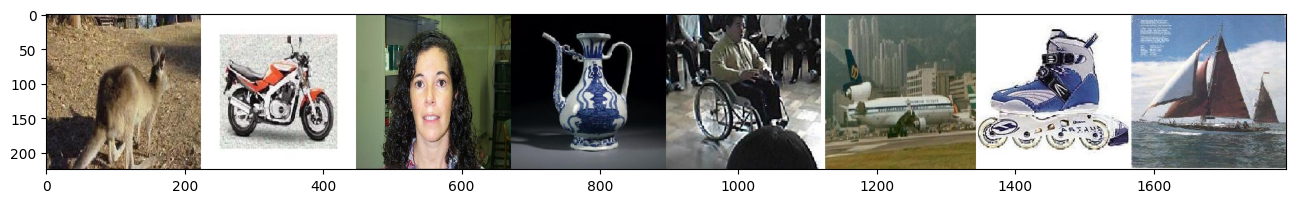

In [62]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Treinando uma rede neural do começo

In [63]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 97)             │        24,929 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 97)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,233,473 (4.71 MB)

 Trainable params: 1,233,473 (4.71 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.0334 - loss: 4.5419 - val_accuracy: 0.0773 - val_loss: 4.3744
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.0852 - loss: 4.3235 - val_accuracy: 0.1192 - val_loss: 4.0902
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1462 - loss: 3.9705 - val_accuracy: 0.2234 - val_loss: 3.7131
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2120 - loss: 3.5994 - val_accuracy: 0.2546 - val_loss: 3.3944
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2674 - loss: 3.2495 - val_accuracy: 0.3050 - val_loss: 3.1063
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3251 - loss: 2.9129 - val_accuracy: 0.3491 - val_loss: 2.9406
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3843 - loss: 2.5839 - val_accuracy: 0.3695 - val_loss: 2.7532
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4600 - loss: 2.2526 - val_accuracy: 0.3942 - val_loss:

Vamos plotar a perda de validação e a precisão da validação ao longo do tempo.

KeyError: 'val_acc'

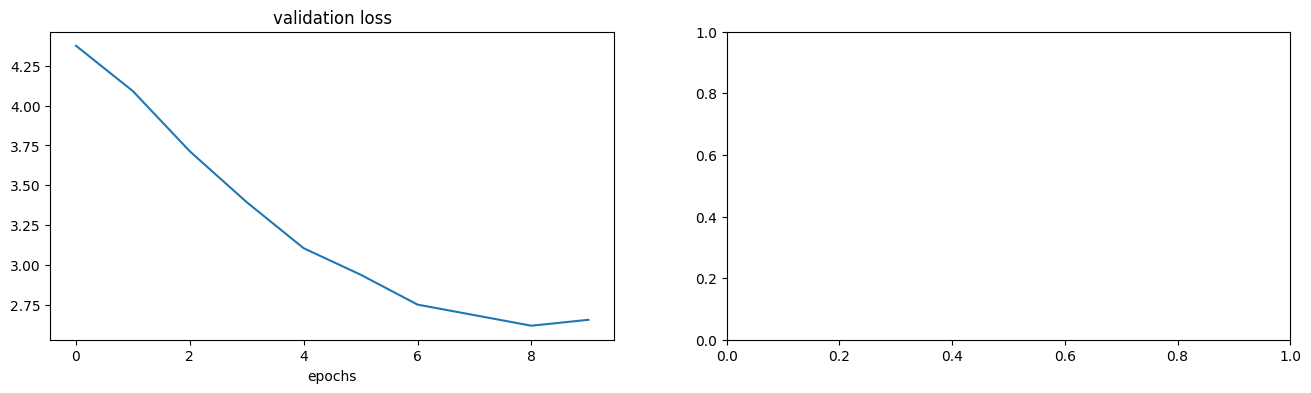

In [65]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [66]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.69049072265625
Test accuracy: 0.41952788829803467


Para começar, vamos carregar o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta é a sua primeira vez carregando VGG16, você precisará esperar um pouco para que os pesos sejam baixados da web. Uma vez que a rede é carregada, podemos novamente inspecionar as camadas com o método 'summary()'.

In [67]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [69]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 97)             │       397,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,657,953 (513.68 MB)

 Trainable params: 397,409 (1.52 MB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [70]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 435s 12s/step - accuracy: 0.0848 - loss: 4.7420 - val_accuracy: 0.3609 - val_loss: 3.0351
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 413s 12s/step - accuracy: 0.4104 - loss: 2.7328 - val_accuracy: 0.4715 - val_loss: 2.3322
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 419s 12s/step - accuracy: 0.5260 - loss: 2.1283 - val_accuracy: 0.5596 - val_loss: 1.9861
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 413s 12s/step - accuracy: 0.6076 - loss: 1.7535 - val_accuracy: 0.6176 - val_loss: 1.6395
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 412s 12s/step - accuracy: 0.6632 - loss: 1.4578 - val_accuracy: 0.6445 - val_loss: 1.5005
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 416s 12s/step - accuracy: 0.6947 - loss: 1.2839 - val_accuracy: 0.6563 - val_loss: 1.4081
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 415s 12s/step - accuracy: 0.7375 - loss: 1.1483 - val_accuracy: 0.6842 - val_loss: 1.2863
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 412s 12s/step - accuracy: 0.7720 - loss: 1.0501 - val_accuracy: 0.

KeyError: 'val_acc'

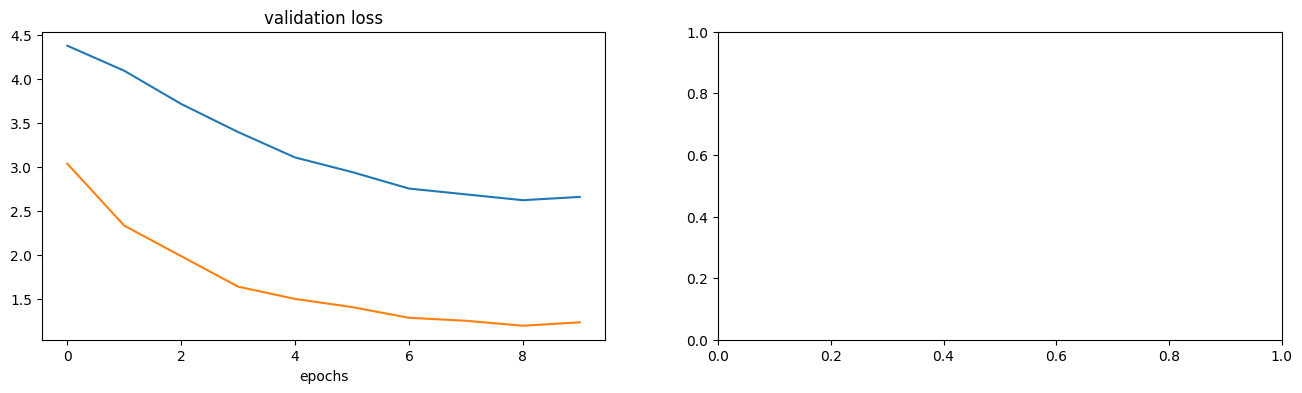

In [71]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_acc"])
ax2.plot(history2.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [72]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.160524845123291
Test accuracy: 0.704935610294342


In [74]:
img, x = get_image('101_ObjectCategories/airplanes/image_0003.jpg')
probabilities = model_new.predict([x])
probabilities

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


array([[6.37246922e-11, 4.70192843e-11, 4.04884290e-14, 8.13006260e-11,
        2.10788800e-11, 8.75134705e-15, 3.65371333e-09, 5.75250458e-10,
        2.06603872e-14, 2.81741280e-11, 2.48925238e-15, 8.00631270e-02,
        1.91838785e-06, 2.74466333e-06, 5.43607111e-16, 1.51454831e-13,
        4.92991498e-13, 8.44241738e-01, 1.63302536e-06, 1.91571006e-15,
        1.86905352e-11, 4.67385199e-15, 8.04436253e-15, 4.42725220e-18,
        1.40209761e-16, 4.65704508e-14, 1.89875604e-17, 8.97802398e-18,
        2.27862228e-19, 1.09513647e-18, 5.49681286e-13, 3.02135617e-12,
        2.43444765e-15, 1.29763691e-11, 3.03032881e-13, 2.30129480e-08,
        4.25211653e-08, 9.27168141e-25, 5.52620151e-14, 1.92993889e-16,
        1.02511918e-13, 3.01731844e-03, 5.93984713e-16, 4.10271589e-14,
        1.98237550e-20, 7.13200346e-02, 3.20078603e-10, 1.78488721e-13,
        1.52391446e-12, 1.46396133e-12, 2.31943247e-08, 1.48669342e-14,
        9.33741725e-17, 1.07619915e-23, 6.15503222e-06, 3.879239